## VGG19 com Symbolic Layer
 Carregar a VGG19
 Criar uma Symbolic Layer com redução de dimensionalidade:
    *Pooling

In [1]:
%%capture

#Imaporta a rede VGG19 ja treinada
from keras.applications.vgg19 import VGG19
model = VGG19()

#Pre-processamento da imagem
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

#Biblioteca para operar sobre o modelo
from keras import models

import numpy as np
from math import sqrt
from random import randint
from numpy import argmax

#Biblioteca do SOM
from minisom import MiniSom

#Bibliotecas do PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
j=0
for i in model.layers[:]:
    print(j, ' ', i.name, ' - ', i.output_shape)
    j+=1

0   input_1  -  (None, 224, 224, 3)
1   block1_conv1  -  (None, 224, 224, 64)
2   block1_conv2  -  (None, 224, 224, 64)
3   block1_pool  -  (None, 112, 112, 64)
4   block2_conv1  -  (None, 112, 112, 128)
5   block2_conv2  -  (None, 112, 112, 128)
6   block2_pool  -  (None, 56, 56, 128)
7   block3_conv1  -  (None, 56, 56, 256)
8   block3_conv2  -  (None, 56, 56, 256)
9   block3_conv3  -  (None, 56, 56, 256)
10   block3_conv4  -  (None, 56, 56, 256)
11   block3_pool  -  (None, 28, 28, 256)
12   block4_conv1  -  (None, 28, 28, 512)
13   block4_conv2  -  (None, 28, 28, 512)
14   block4_conv3  -  (None, 28, 28, 512)
15   block4_conv4  -  (None, 28, 28, 512)
16   block4_pool  -  (None, 14, 14, 512)
17   block5_conv1  -  (None, 14, 14, 512)
18   block5_conv2  -  (None, 14, 14, 512)
19   block5_conv3  -  (None, 14, 14, 512)
20   block5_conv4  -  (None, 14, 14, 512)
21   block5_pool  -  (None, 7, 7, 512)
22   flatten  -  (None, 25088)
23   fc1  -  (None, 4096)
24   fc2  -  (None, 4096)
25   pre

In [3]:
import os
import glob
#Vetor com os nomes das imagens na pasta
imgs = []
os.chdir("/home/gustavo/PROG/images/val2017/")
for file_name in glob.glob("*.jpg"):
    imgs.append(file_name)
print("Numero de imagens: ", len(imgs))

#simb_net = SymbolicNet(model)
#simb_net.netLoad("/home/gustavo/JUPITER-LAB/networks/net_VGG19_3_40", model)

Numero de imagens:  45670


In [4]:
#DEFINIR O CODIGO PARA O POOLING_RATIO
def Pooling(feature_map, pooling_ratio = 2, pooling_type = "max", change = True):
    #Alterar os feature maps para cada elemento ser uma camada de ativacoes da CNN: (1, x, x, y) ----> (1, y, x, x)
    init_shape = np.shape(feature_map)
    if (change):
        new_map = []
        for i in range(int(init_shape[3])):
            aux = np.empty((init_shape[1], init_shape[2]))
            for j in range(int(init_shape[2])):
                for k in range(int(init_shape[1])):
                    aux[k][j] = feature_map[0][k][j][i]
            new_map.append(aux)  
        new_map = [new_map]
    else:
        new_map = feature_map
        
    #Testa se a dimensao e divisival pelo pooling ratio, caso positivo realiza o pooling
    if((pooling_ratio != 1)and(init_shape[1]%pooling_ratio == 0)and(init_shape[2]%pooling_ratio == 0)):
        new_map_red = []
        for conv_map in new_map[0]:
            aux = np.empty((int(conv_map.shape[0]/pooling_ratio), int(conv_map.shape[1]/pooling_ratio)))
            l=0
            for i in range(0, conv_map.shape[0], pooling_ratio):
                c=0
                for j in range(0, conv_map.shape[1], pooling_ratio):
                    cell = conv_map[i:i+pooling_ratio, j:j+pooling_ratio]
                    if(pooling_type == 'max'):
                        aux[l][c] = np.amax(cell)
                    elif(pooling_type == 'mean'):
                        aux[l][c] = np.sum(cell)/4
                    c+=1
                l+=1 
            new_map_red.append(aux)
    else:
        new_map_red = new_map[0]
        if(pooling_ratio != 1): print("Impossivel dividir: ", str(init_shape[1:3]), " por ", pooling_ratio)
    new_map_red = [new_map_red]
    return new_map_red

In [38]:
import matplotlib.pyplot as plt
layer_outputs = model.layers[16].output 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input
n=np.random.randint(0, len(imgs))
img = load_img('/home/gustavo/PROG/images/val2017/'+imgs[n], target_size=(224, 224))
img_aux = img_to_array(img)
img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
img_aux = preprocess_input(img_aux)

layer = activation_model.predict(img_aux)
print(np.shape(layer))
#layer = layerPCA(layer, 16)
#print(np.shape(layer))

(1, 14, 14, 512)


25088


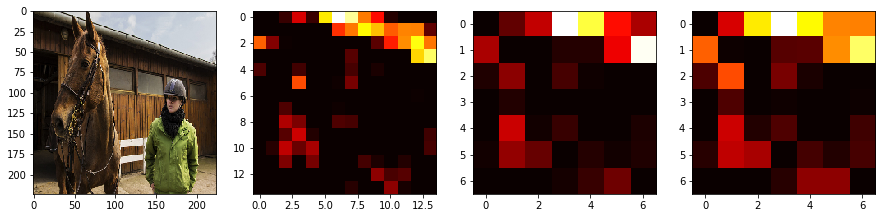

In [43]:
layer_1 = Pooling(feature_map = layer, pooling_ratio = 1, pooling_type = 'max')
red_layer_mean = Pooling(feature_map = layer, pooling_ratio = 2, pooling_type = 'mean')
red_layer_max = Pooling(feature_map = layer, pooling_ratio = 2, pooling_type = 'max')
print(np.prod(np.shape(red_layer_mean)))
num = 99
n1 = 4
n2 = 10
plt.subplot(n1, n2, 1)
plt.imshow(img)

plt.subplot(n1, n2, 2)
plt.imshow(layer_1[0][num], cmap = 'hot')

plt.subplot(n1, n2, 3)
plt.imshow(red_layer_mean[0][num], cmap = 'hot')

plt.subplot(n1, n2, 4)
plt.imshow(red_layer_max[0][num], cmap = 'hot')


plt.subplots_adjust(left=0, bottom=0, right=5, top=10, wspace=0.2, hspace=0.2)
plt.show()

In [7]:
model.layers[16].output_shape[1:]

(14, 14, 512)

In [8]:
%%capture
class SymbolicLayer:
    
    def __init__(self, cnn_model, cnn_input_layer):
        self.cnn_model = cnn_model #CNN
        self.cnn_input_layer = cnn_input_layer #numero da camada da CNN da qual sera retirado o feature map de entrada da camada
        
        #Variaveis cradas na layerCreate
        self.layer_input_size = None #Numero de elementos do feature vector de entrada: 235711
        self.soms_num = None #Numero de SOMs na entrada dessa camada: 2
        self.soms_shapes = None #Arranjo com as dimensoes de cada SOM: ((10, 10), (15, 15))
        self.output_shape = None #Arranjo com as dimensoes do SOM de saida: (30, 30)
        self.layer_branches = None #Arranjo com cada SOM da camada
        self.soms_input_size = None #Tamanho do input de cada SOM - é o mesmo para todas: 2343
        self.last_layer_input_size = None #Numero de elementos na entrada do SOM de saida: 4500
        self.out_layer = None #SOM de saida
        self.pooling = None #Flag para a realizacao de pooling (2, 2) nos feature maps antes do treino: True
        self.pooling_ratio = None #O quanto cada um dos filtros sera reduzido: 3 ----> (120, 12, 12) => (120, 4, 4)
        self.sigma = None #Array com os valored do sigma das soms de entrada e saida: ((3, 2, 5, 7), 6) ---> 4 SOMs de entrada e um SOM de saida
        self.learning_rate = None #Array com os valores do learning rate das soms de entrada e saida: ((0.8, 0.5, 0.2, 0.4), 1) ---> 4 SOMs de entrada e um SOM de saida
        self.activation_model = None #Modelo que tem como saida a camada da CNN desejada 
    #--------------------------------------------------------------------------
     
    def layerCreate(self, soms_num, soms_shapes, output_shape, sigma, learning_rate, pooling = True, pooling_ratio = 1):
        self.soms_num = soms_num 
        self.soms_shapes = soms_shapes
        self.output_shape = output_shape
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.pooling = pooling
        self.pooling_ratio = pooling_ratio
        
        layer_outputs = self.cnn_model.layers[self.cnn_input_layer].output
        self.activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
        input_fv_shape = self.cnn_model.layers[self.cnn_input_layer].output_shape
        
        #Se os poolings nao forem compativeis com o tamanho dos filtros a camada nao e criada
        if((input_fv_shape[1]%self.pooling_ratio == 0)and(input_fv_shape[2]%self.pooling_ratio == 0)):
            #Definir o tamanho do input com os poolings
            self.layer_input_size = np.prod(input_fv_shape[1:])/(self.pooling_ratio*self.pooling_ratio)

            #Criar o arranjo com os SOMs daquela camada
            self.layer_branches = []
            while (input_fv_shape[3]%self.soms_num != 0):
                self.soms_num += 1
            if(soms_num != self.soms_num): print("Numero de SOMs alterado de ", soms_num, " para ", self.soms_num)
            self.soms_input_size = self.layer_input_size/self.soms_num
            for i in range(self.soms_num):
                som_aux = MiniSom(int(self.soms_shapes[i][0]), int(self.soms_shapes[i][1]), int(self.soms_input_size), self.sigma[0][i], self.learning_rate[0][i])
                self.layer_branches.append(som_aux)  
                
            #Calcular o numero de elementos que entrarão na camada de saida
            self.last_layer_input_size = 0
            for shape_aux in self.soms_shapes:
                self.last_layer_input_size += np.prod(shape_aux)

            #Criar a camada de saida
            self.out_layer = MiniSom(int(self.output_shape[0]), int(self.output_shape[1]), self.last_layer_input_size, self.sigma[1], self.learning_rate[1])
        
        else: print("Impossivel criar camada: pooling_ratio invalida")
    #--------------------------------------------------------------------------
        
    def layerTrain(self, image, trains_per_image=20):
        #train_feature_map - Feature map que sera o input da camada ---> direto da camada da CNN
        #trains_per_image - Numero de vezes que um mesmo feature map sera usado no treino das SOMs de entrada
        img = load_img('/home/gustavo/PROG/images/val2017/'+image, target_size=(224, 224))
        img_aux = img_to_array(img)
        img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
        img_aux = preprocess_input(img_aux)
        #Passar a imagem pela rede e salvar a ativação das camadas escolhidas 
        train_feature_map = self.activation_model.predict(img_aux) 
        train_feature_map = self.layerPooling(feature_map = train_feature_map, pooling_ratio = self.pooling_ratio, pooling_type = 'rand')
        som_in_length = np.shape(train_feature_map)[1]/self.soms_num
        #Dividir o feature map de entrada e treinar cada SOM de entrada com a sua parcela correspondente
        layer_input = []
        for i in range(self.soms_num):
            #print(i, ' ', np.shape(train_feature_map))
            feature_map = train_feature_map[0][int(i*som_in_length):int((i+1)*som_in_length)]
            #print(np.shape(feature_map))
            feature_map = np.reshape(feature_map, (np.prod(np.shape(feature_map))))
            self.layer_branches[i].train([feature_map], trains_per_image)
            map_aux = self.layer_branches[i].activate(feature_map)
            map_aux = np.reshape(map_aux, np.prod(np.shape(map_aux)))
            layer_input.append(map_aux)
        #Concatenar a saida gerada pelas SOMs de entrada e linearizar
        layer_input = np.concatenate(layer_input)
        layer_input = np.reshape(layer_input, (1, np.prod(np.shape(layer_input))))
        #Treina o SOM de saida com o feature vector das SOMs de entrada
        self.out_layer.train(layer_input, trains_per_image)
        return (self.out_layer.activate(layer_input))
    #--------------------------------------------------------------------------
    
    def layerGenerateMap(self, image, change=False, limit=0):
        #feature_map - Feature map do qual sera gerado o mapa
        img = load_img('/home/gustavo/PROG/images/val2017/'+image, target_size=(224, 224))
        img_aux = img_to_array(img)
        img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
        img_aux = preprocess_input(img_aux)
        
        #Passar a imagem pela rede e salvar a ativação das camadas escolhidas 
        train_feature_map = self.activation_model.predict(img_aux) 
        train_feature_map = self.layerPooling(train_feature_map, pooling_ratio = self.pooling_ratio, pooling_type = 'rand')
        som_in_length = np.shape(train_feature_map)[1]/self.soms_num
        
        #Separar o feature map entre os SOMs de entrada e gerar os mapas
        layer_input = []
        for i in range(self.soms_num):
            partial_feature_map = train_feature_map[0][int(i*som_in_length):int((i+1)*som_in_length)]
            partial_feature_map = np.reshape(partial_feature_map, (np.prod(np.shape(partial_feature_map))))
            layer_input.append(np.reshape( self.layer_branches[i].activate(partial_feature_map), (int(self.soms_shapes[i][0])*int(self.soms_shapes[i][1]))))
        
        #Concatenar e redimensionar os mapas de saida dos SOMs de entrada
        layer_input = np.concatenate(layer_input)
        layer_input = np.reshape(layer_input, (1, self.last_layer_input_size))
        
        #Gerar o mapa de saida
        out = self.out_layer.activate(layer_input)
        
        #Normalizar os dados (0 <= x <= 1), Inverter o mapa (por algum motivo fica melhor), Zerar os valores menores que um limite (tirar interferencia)
        f_min, f_max = np.amin(out), np.amax(out)
        out = (out - f_min) / (f_max - f_min)
        if(change):
            out = 1 - out 
        if(limit != 0):
            for j in range(np.shape(out)[0]):
                for k in range(np.shape(out)[1]):
                    if(out[j][k] < limit): out[j][k] = 0
        return out
    #--------------------------------------------------------------------------
    
    def layerPooling(self, feature_map, pooling_ratio = 1, pooling_type = "max", change = True):
        #Alterar os feature maps para cada elemento ser uma camada de ativacoes da CNN: (1, x, x, y) ----> (1, y, x, x)
        init_shape = np.shape(feature_map)
        if (change):
            new_map = []
            for i in range(int(init_shape[3])):
                aux = np.empty((init_shape[1], init_shape[2]))
                for j in range(int(init_shape[2])):
                    for k in range(int(init_shape[1])):
                        aux[k][j] = feature_map[0][k][j][i]
                new_map.append(aux)  
            new_map = [new_map]
        else:
            new_map = feature_map

        #Testa se a dimensao e divisival pelo pooling ratio, caso positivo realiza o pooling
        if((pooling_ratio != 1)and(init_shape[1]%pooling_ratio == 0)and(init_shape[2]%pooling_ratio == 0)):
            new_map_red = []
            for conv_map in new_map[0]:
                aux = np.empty((int(conv_map.shape[0]/pooling_ratio), int(conv_map.shape[1]/pooling_ratio)))
                l=0
                for i in range(0, conv_map.shape[0], pooling_ratio):
                    c=0
                    for j in range(0, conv_map.shape[1], pooling_ratio):
                        cell = conv_map[i:i+pooling_ratio, j:j+pooling_ratio]
                        if(pooling_type == 'max'):
                            aux[l][c] = np.amax(cell)
                        elif(pooling_type == 'mean'):
                            aux[l][c] = np.sum(cell)/np.prod(np.shape(cell))
                        elif(pooling_type == 'rand'):
                            opt = np.random.randint(2)
                            if (opt == 0): aux[l][c] = np.amax(cell)
                            elif (opt == 1): aux[l][c] = np.sum(cell)/np.prod(np.shape(cell))
                        c+=1
                    l+=1 
                new_map_red.append(aux)
        else:
            new_map_red = new_map[0]
            if(pooling_ratio != 1): print("Impossivel dividir: ", str(init_shape[1:3]), " por ", pooling_ratio) 
        
        f_min, f_max = np.amin(new_map_red), np.amax(new_map_red)
        new_map_red = (new_map_red - f_min) / (f_max - f_min)
        new_map_red = [new_map_red]
        return new_map_red

    #--------------------------------------------------------------------------
    
    def layerSave(self, layer_path):
        #Nome dos arquivos dos SOMs
            #SOMs de entrada
                #som_in_"somNum"_"somDim".p
                    #somNum - numero daquele SOM na sub layer: 0
                    #somDim - uma das dimensoes do SOM: 30
            #SOM de saida
                #som_out.p

        #Iterar pelos SOMs da sub layer e salva los de acordo com o nome definido
        som_cont = 0
        for som in self.layer_branches:
            som_filename = layer_path+"/somin_"+str(som_cont)+"_"+str(self.soms_shapes[som_cont][0])+"_.p"
            # saving the som in the file som.p
            with open(som_filename, 'wb') as outfile:
                pickle.dump(som, outfile)
            som_cont += 1

        #Salvar o SOM de saida
        out_layer_path = layer_path+"/somout.p"
        with open(out_layer_path, 'wb') as outfile:
            pickle.dump(self.out_layer, outfile)
    #--------------------------------------------------------------------------
    
    def layerLoad(self, layer_path):
        #Pegar as informacoes da camada pelo nome da pasta
        layer_infos = layer_path.split("/")[-1]
        layer_infos = layer_infos.split("_")[2:]
        #Definir as variaveis da camada
        self.layer_input_size = int(layer_infos[0])
        self.output_shape = (int(layer_infos[1]), int(layer_infos[1]))
        self.soms_num = int(layer_infos[2])
               
        self.soms_shapes = []
        self.layer_branches = []
        self.soms_input_size = self.layer_input_size/self.soms_num
        
        #Pegar os nomes de todos os arquivos na pasta
        soms_filenames = []
        os.chdir(layer_path+"/")
        for file_name in glob.glob("*.p"):
            file_name = "/"+file_name
            if(file_name != "/somout.p"):
                soms_filenames.append(file_name)        
        soms_filenames = natsort.natsorted(soms_filenames,reverse=False)

        #Carregar todos os SOMs de entrada
        for filename in soms_filenames:
            infos = filename.split("_")[:-1]
            if(infos[0] == "/somin"):
                with open(layer_path+filename, 'rb') as infile:
                    self.layer_branches.append(pickle.load(infile))
                    self.soms_shapes.append((int(infos[2]), int(infos[2])))
        self.last_layer_input_size = sum(np.prod(som_shape) for som_shape in self.soms_shapes)
        
        #Carregar o som de saida
        with open(layer_path+"/somout.p", 'rb') as infile:
            self.out_layer = pickle.load(infile)  
        
        #Retornar as dimensoes dos SOMs para salvar nos parametros da rede
        return self.soms_shapes
    #--------------------------------------------------------------------------

In [9]:
layer = 16
soms_num = 4
soms_shapes = []
sigma = [[]]
learning_rate = [[]]
for _ in range(soms_num):
    soms_shapes.append((np.random.randint(10, 15), np.random.randint(25, 30)))
    sigma[0].append(np.random.randint(2, 5))
    learning_rate[0].append(np.random.uniform(0.1, 0.2))
sigma.append(3)
learning_rate.append(0.07)
out_shape = (40, 40)
print(soms_shapes)
simb_layer = SymbolicLayer(model, layer)

[(10, 25), (13, 27), (14, 25), (14, 26)]


In [10]:
simb_layer.layerCreate(soms_num, soms_shapes, out_shape, sigma, learning_rate)

In [11]:
num = 2000
verb = 100
for i in range(num):
    n = np.random.randint(0, len(imgs))
    simb_layer.layerTrain(imgs[n])
    if(i%verb == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


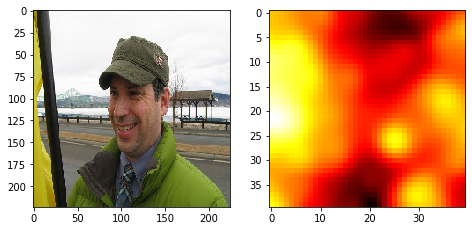

In [23]:
n = np.random.randint(1000, 15000)
img = load_img('/home/gustavo/PROG/images/val2017/'+imgs[n], target_size=(224, 224))
mapster = simb_layer.layerGenerateMap(imgs[n], change=False, limit = 0.0)
n1 = 2
plt.subplot(n1, n1, 1)
plt.imshow(img)

plt.subplot(n1, n1, 2)
plt.imshow(mapster, cmap = 'hot')

plt.subplots_adjust(left=2, bottom=0, right=3, top=3, wspace=0.2, hspace=0.2)
plt.show()